In [6]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
import keras.backend as K
import tensorflow as tf
import pandas as pd


In [7]:
train_dir = r'data/RiceLeafsDisease/train/'
test_dir = r'data/RiceLeafsDisease/validation/'

val_loss = list()
val_accuracy = list()
test_loss= list()
test_accuracy = list()

In [8]:
BATCH_SIZE = 32
seeds = 41
im_shape = (250,250)

In [9]:
# Load and preprocess the training data
train_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,width_shift_range=0.2,horizontal_flip=True,validation_split=0.2)
val_data_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,width_shift_range=0.2,horizontal_flip=True,validation_split=0.2)
test_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,width_shift_range=0.2,horizontal_flip=True)

# Generator of Train
train_generator = train_generator.flow_from_directory(train_dir, target_size=im_shape, shuffle=True, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE, subset="training")
# Generator of validation
validation_generator = val_data_generator.flow_from_directory(train_dir, target_size=im_shape, shuffle=False, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE, subset="validation")

# Generator of dataset test
test_generator = test_generator.flow_from_directory(test_dir, target_size=im_shape, shuffle=False, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)


Found 1680 images belonging to 6 classes.
Found 420 images belonging to 6 classes.
Found 528 images belonging to 6 classes.
Classes: ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot']


# InceptionResNet Model 

In [12]:
from keras.layers import Input, Conv2D, DepthwiseConv2D, Concatenate, Add, GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, AveragePooling2D

def inception_module(x, filters):
    # Branch 1:1 x1 convolution
    branch_1x1 = Conv2D(filters=filters[0], kernel_size=(1, 1), strides=1, padding='same', activation='relu')(x)

    # Branch 2: depth-separable convolution (3x3)
    branch_3x3 = DepthwiseConv2D(kernel_size=(3, 3), strides=1, padding='same', activation='relu')(x)
    branch_3x3 = Conv2D(filters=filters[1], kernel_size=(1, 1), strides=1, padding='same', activation='relu')(branch_3x3)

    # Branch 3: Depth-separable Convolution (5x5)
    branch_5x5 = DepthwiseConv2D(kernel_size=(5, 5), strides=1, padding='same', activation='relu')(x)
    branch_5x5 = Conv2D(filters=filters[2], kernel_size=(1, 1), strides=1, padding='same', activation='relu')(branch_5x5)

    # The branch 4:3x3 is maximized and then convolved with 1x1
    branch_pool = AveragePooling2D(pool_size=(3, 3), strides=1, padding='same')(x)
    branch_pool = Conv2D(filters=filters[3], kernel_size=(1, 1), strides=1, padding='same', activation='relu')(branch_pool)

    output = Concatenate(axis=-1)([branch_1x1, branch_3x3, branch_5x5, branch_pool])
    return output

def residual_block(x, filters):
    # Save the input for subsequent residual connections
    shortcut = x

    # The first Inception module
    x = inception_module(x, filters)

    # The Second Inception module
    x = inception_module(x, filters)

    # If the input and output dimensions do not match, the dimensions are adjusted using 1x1 convolution
    if shortcut.shape[-1] != x.shape[-1]:
        shortcut = Conv2D(filters=x.shape[-1], kernel_size=(1, 1), strides=1, padding='same')(shortcut)

    # Residual connection
    x = Add()([shortcut, x])
    x = tf.keras.layers.Activation('relu')(x)
    return x

# Input Layer
input_layer = Input(shape=(250, 250, 3))

# Convolution layer
conv1 = Conv2D(64, (5, 5), strides=(2, 2), padding='same', activation='relu')(input_layer)

# Residual block
res_block1 = residual_block(conv1, [32, 64, 128, 32])
res_block2 = residual_block(res_block1, [64, 64, 128, 32])

pool2 = GlobalAveragePooling2D()(res_block2)
dense = Dense(2048, activation='relu')(pool2)
# Fully connected layer
flatten = Flatten()(dense)

output_layer = Dense(6, activation='softmax')(flatten)

model = Model(inputs=input_layer, outputs=output_layer)

In [13]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 250, 250, 3)]        0         []                            
                                                                                                  
 conv2d_48 (Conv2D)          (None, 125, 125, 64)         4864      ['input_4[0][0]']             
                                                                                                  
 depthwise_conv2d_20 (Depth  (None, 125, 125, 64)         640       ['conv2d_48[0][0]']           
 wiseConv2D)                                                                                      
                                                                                                  
 depthwise_conv2d_21 (Depth  (None, 125, 125, 64)         1664      ['conv2d_48[0][0]']     

In [14]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
import time
# Record the start time of training
start_time = time.time()

In [16]:
# Train the model
epochs = 10

#Callback to save the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='Depth_Incep_Res_model_with_DA.h5',
        monitor='val_loss', save_best_only=True, verbose=1)
]

#Training
history_1 = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // BATCH_SIZE)

Epoch 1/10


2024-04-15 13:18:41.587685: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-04-15 13:18:44.896682: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-15 13:18:44.921187: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x21c33890 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-15 13:18:44.921268: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2024-04-15 13:18:44.933023: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-15 13:18:45.111513: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


52/52 [==============================] - ETA: 0s - loss: 1.7763 - accuracy: 0.1911
Epoch 1: val_loss improved from inf to 1.78919, saving model to Depth_Incep_Res_model_with_DA.h5
52/52 [==============================] - 68s 929ms/step - loss: 1.7763 - accuracy: 0.1911 - val_loss: 1.7892 - val_accuracy: 0.1899
Epoch 2/10


/environment/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


52/52 [==============================] - ETA: 0s - loss: 1.6350 - accuracy: 0.2979
Epoch 2: val_loss improved from 1.78919 to 1.59763, saving model to Depth_Incep_Res_model_with_DA.h5
52/52 [==============================] - 44s 844ms/step - loss: 1.6350 - accuracy: 0.2979 - val_loss: 1.5976 - val_accuracy: 0.3317
Epoch 3/10
52/52 [==============================] - ETA: 0s - loss: 1.3748 - accuracy: 0.4320
Epoch 3: val_loss improved from 1.59763 to 1.24417, saving model to Depth_Incep_Res_model_with_DA.h5
52/52 [==============================] - 46s 871ms/step - loss: 1.3748 - accuracy: 0.4320 - val_loss: 1.2442 - val_accuracy: 0.4495
Epoch 4/10
52/52 [==============================] - ETA: 0s - loss: 1.2085 - accuracy: 0.5170
Epoch 4: val_loss improved from 1.24417 to 1.13142, saving model to Depth_Incep_Res_model_with_DA.h5
52/52 [==============================] - 47s 897ms/step - loss: 1.2085 - accuracy: 0.5170 - val_loss: 1.1314 - val_accuracy: 0.5409
Epoch 5/10
52/52 [============

In [17]:
# Record the training end time
end_time = time.time()

In [18]:
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Training time: 489.62119364738464 seconds


In [19]:
pd.DataFrame(history_1.history)

,loss,accuracy,val_loss,val_accuracy
0,1.776272,0.191141,1.789192,0.189904
1,1.635022,0.297937,1.597628,0.331731
2,1.374835,0.432039,1.244171,0.449519
3,1.208516,0.516990,1.131420,0.540865
4,1.047802,0.605583,1.145497,0.593750
5,0.973213,0.629248,1.027252,0.591346
6,0.878340,0.668689,1.141139,0.567308
7,0.938441,0.651699,0.987402,0.610577
8,0.812053,0.690534,1.333061,0.451923
9,0.836547,0.694175,1.108134,0.600962


In [20]:
import joblib

joblib.dump(history_1.history,'history_CNN1.pkl')
history_CNN1 = joblib.load('history_CNN1.pkl')

In [21]:
def plot_performance(model_name, acc, val_acc, loss, val_loss):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('{} : Loss'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.subplot(1,2,2)
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('{} : Accuracy'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.tight_layout()

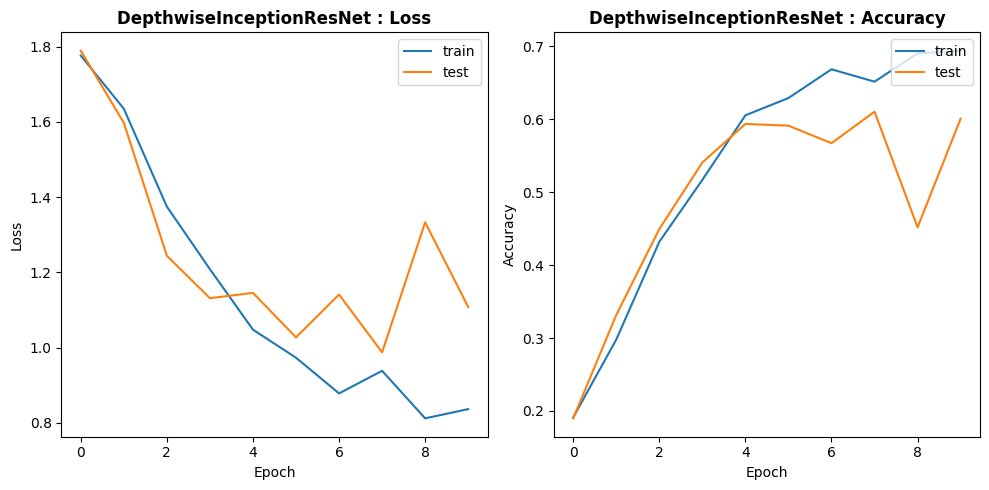

In [22]:
plot_performance(model_name='DepthwiseInceptionResNet',
                acc=history_CNN1['accuracy'], 
                 val_acc=history_CNN1['val_accuracy'],
                 loss=history_CNN1['loss'], 
                 val_loss=history_CNN1['val_loss'])

In [24]:
# Load the best saved model
from keras.models import load_model

model = load_model('Depth_Incep_Res_model_with_DA.h5')
score = model.evaluate(validation_generator)
val_loss.append(score[0])
val_accuracy.append(score[1])
print('\nVal loss:', score[0])
print('Val accuracy:', score[1])

score = model.evaluate(test_generator)
print('\nTest loss:', score[0])
print('Test accuracy:', score[1])

test_loss.append(score[0])
test_accuracy.append(score[1])

14/14 [==============================] - 9s 630ms/step - loss: 0.9647 - accuracy: 0.6238

Val loss: 0.9646872878074646
Val accuracy: 0.6238095164299011
17/17 [==============================] - 12s 683ms/step - loss: 0.8531 - accuracy: 0.6951

Test loss: 0.8531433343887329
Test accuracy: 0.6950757503509521


In [25]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

17/17 [==============================] - 12s 706ms/step
Classification Report
                       precision    recall  f1-score   support

bacterial_leaf_blight       0.71      0.84      0.77        88
           brown_spot       0.68      0.41      0.51        88
              healthy       0.81      0.80      0.80        88
           leaf_blast       0.59      0.47      0.52        88
           leaf_scald       0.61      0.88      0.72        88
    narrow_brown_spot       0.68      0.69      0.69        88

             accuracy                           0.68       528
            macro avg       0.68      0.68      0.67       528
         weighted avg       0.68      0.68      0.67       528



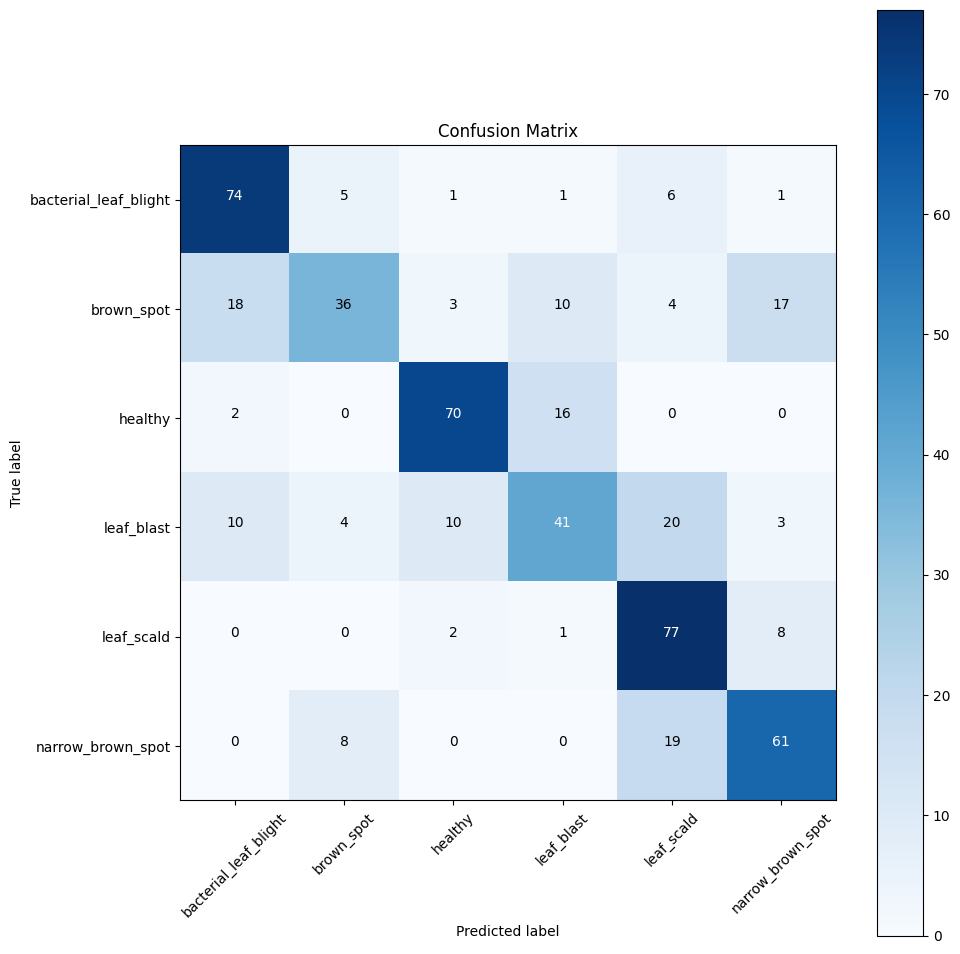

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

#Confution Matrix and Classification Report
Y_pred = model.predict(test_generator)#, nb_test_samples // BATCH_SIZE, workers=1)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names, zero_division=1))

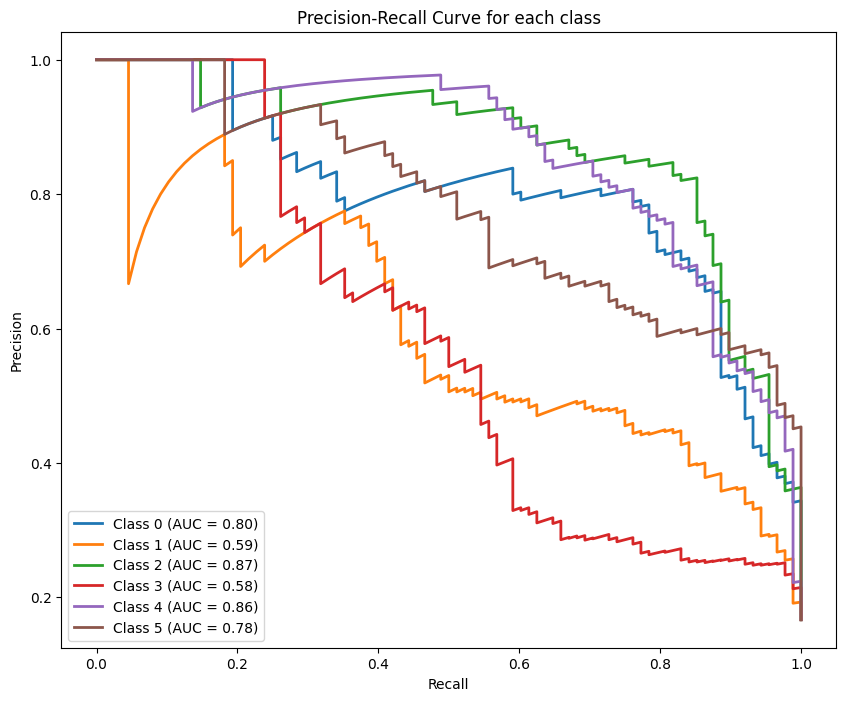

In [27]:
# Precision-Recall Curve for each class
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

n_classes = len(classes)
y_true_bin = label_binarize(test_generator.classes, classes=list(range(n_classes)))
precision = dict()
recall = dict()
auc_score = dict()

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], Y_pred[:, i])
    auc_score[i] = auc(recall[i], precision[i])
    
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (AUC = {auc_score[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for each class')
plt.legend(loc="best")
plt.show()

In [28]:
#Generate predictions for the test dataset
y_pred = model.predict(test_generator)
y_pred_labels = (y_pred>0.5).astype(int)

#Get the true labels from thee test generator
y_true = test_generator.classes

17/17 [==============================] - 11s 660ms/step


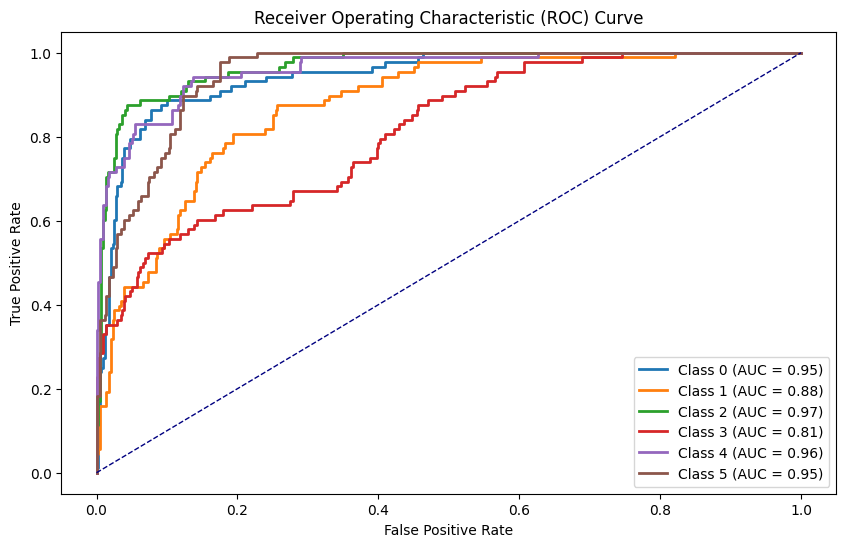

In [29]:
# Compute ROC curve
from sklearn.metrics import roc_curve, auc

#Get the true labels from thee test generator
# y_true = test_generator.classes
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

# Initialize arrays to store fpr, tpr, and auc for each class
fpr = dict()
tpr = dict()
roc_auc = dict()


# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

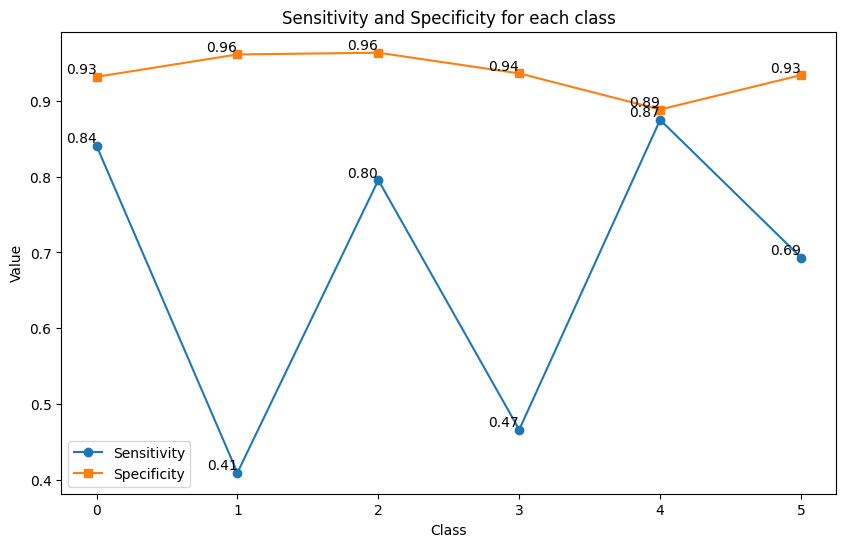

In [30]:
# Initialize the list of Sensitivity and Specificity for each class
sensitivity_list = []
specificity_list = []

# The Sensitivity and Specificity of each class were calculated
for i in range(len(cm)):
    tp = cm[i, i]  # True Positive
    fn = np.sum(cm[i, :]) - tp  # False Negative
    fp = np.sum(cm[:, i]) - tp  # False Positive
    tn = np.sum(cm) - (tp + fn + fp)  # True Negative
    
    sensitivity = tp / (tp + fn + 1e-10)  # Add a small number to avoid dividing by zero
    specificity = tn / (tn + fp + 1e-10)
    
    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)

# Plot Sensitivity and Specificity for each class
plt.figure(figsize=(10, 6))
plt.plot(range(len(sensitivity_list)), sensitivity_list, marker='o', label='Sensitivity')
plt.plot(range(len(specificity_list)), specificity_list, marker='s', label='Specificity')
plt.xlabel('Class')
plt.ylabel('Value')
plt.title('Sensitivity and Specificity for each class')
plt.legend()

# Add numeric labels
for i, (sensitivity, specificity) in enumerate(zip(sensitivity_list, specificity_list)):
    plt.text(i, sensitivity, f'{sensitivity:.2f}', ha='right', va='bottom')
    plt.text(i, specificity, f'{specificity:.2f}', ha='right', va='bottom')

plt.show()

In [31]:
print(sensitivity_list)
print(specificity_list)

[0.8409090909081353, 0.4090909090904442, 0.7954545454536415, 0.4659090909085615, 0.8749999999990057, 0.6931818181810304]
[0.93181818181797, 0.9613636363634179, 0.9636363636361447, 0.9363636363634236, 0.8886363636361617, 0.9340909090906968]


In [32]:
# Evaluate the performance of the model
evaluate = model.evaluate(
    test_generator, 
    steps = test_generator.n // BATCH_SIZE, 
    verbose = 1
)

print('Accuracy Test : {}'.format(evaluate[1]))

16/16 [==============================] - 12s 722ms/step - loss: 0.8598 - accuracy: 0.6719
Accuracy Test : 0.671875
